# Image Data with PyTorch

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# MNIST IMAGE --> Tensors

In [5]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='../Data', train = True, download=True, transform = transform)

3.3%

100.0%


Extracting ../Data\MNIST\raw\train-images-idx3-ubyte.gz to ../Data\MNIST\raw


100.0%
2.0%


Extracting ../Data\MNIST\raw\train-labels-idx1-ubyte.gz to ../Data\MNIST\raw



100.0%
100.0%

Extracting ../Data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../Data\MNIST\raw

Extracting ../Data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../Data\MNIST\raw



In [6]:
test_data = datasets.MNIST(root='../Data', train = False, download=True, transform=transform)

In [8]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [9]:
label

5

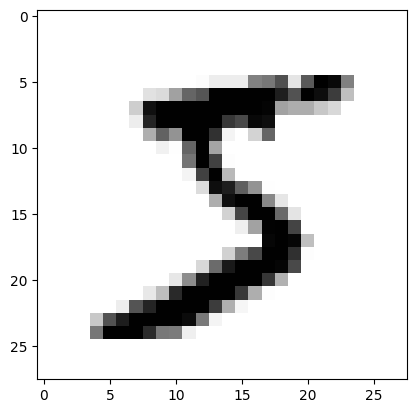

In [13]:
plt.imshow(image.reshape((28,28)), cmap = 'gist_yarg');

In [14]:
 torch.manual_seed(101)
 train_loader = DataLoader(train_data, batch_size = 100, shuffle = True)
 test_loader = DataLoader(test_data, batch_size = 500, shuffle = False)

In [15]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [16]:
for images_batch, labels_batch in train_loader:
    break

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


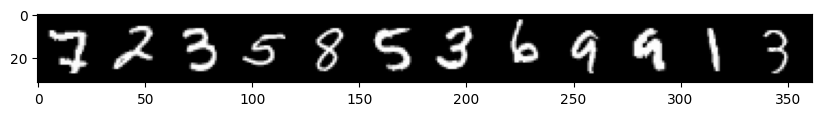

In [20]:
print('Labels: ', labels_batch[:12].numpy())
im = make_grid(images_batch[:12], nrow = 12)
plt.figure(figsize = (10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)));

In [21]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_sz = 784, out_sz = 10, layers = [120, 84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim = 1) # MULTI CLASS CLASSIFICATION

In [40]:
torch.manual_seed(101)
model = MultiLayerPerceptron()
model.eval()

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
# ANN --> CNN
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [26]:
images_batch.shape # --> [100, 784]

torch.Size([100, 1, 28, 28])

In [28]:
images_batch.view(100, -1).shape

torch.Size([100, 784])

In [42]:
import time
start_time = time.time()
epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            acc = trn_corr.item() * 100/(100 * b)
            print(f'Epoch {i} batch {b} loss: {loss.item()} accuracy: {acc}')

    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr.numpy())

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted==y_test).sum()
            
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)


total_time = time.time() - start_time
print(f'Duration: {total_time/60: .2f} mins')

Epoch 0 batch 200 loss: 0.2356237918138504 accuracy: 83.245
Epoch 0 batch 400 loss: 0.3533071279525757 accuracy: 87.5325
Epoch 0 batch 600 loss: 0.13734403252601624 accuracy: 89.58166666666666
Epoch 1 batch 200 loss: 0.24684995412826538 accuracy: 94.87
Epoch 1 batch 400 loss: 0.1427389681339264 accuracy: 95.085
Epoch 1 batch 600 loss: 0.07336548715829849 accuracy: 95.355
Epoch 2 batch 200 loss: 0.08371468633413315 accuracy: 96.515
Epoch 2 batch 400 loss: 0.06228961795568466 accuracy: 96.6125
Epoch 2 batch 600 loss: 0.0645318254828453 accuracy: 96.705
Epoch 3 batch 200 loss: 0.11824803054332733 accuracy: 97.655
Epoch 3 batch 400 loss: 0.05599313601851463 accuracy: 97.495
Epoch 3 batch 600 loss: 0.03123941272497177 accuracy: 97.50166666666667
Epoch 4 batch 200 loss: 0.10904983431100845 accuracy: 98.13
Epoch 4 batch 400 loss: 0.049284372478723526 accuracy: 97.965
Epoch 4 batch 600 loss: 0.05629672110080719 accuracy: 97.96833333333333
Epoch 5 batch 200 loss: 0.007767381612211466 accuracy: 

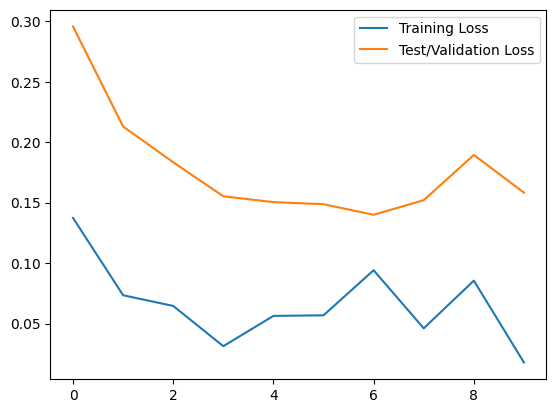

In [43]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Test/Validation Loss')
plt.legend()

In [46]:
train_acc = [t/600 for t in train_correct]
train_acc

[89.58166666666666,
 95.355,
 96.705,
 97.50166666666667,
 97.96833333333333,
 98.37833333333333,
 98.63666666666667,
 98.90333333333334,
 99.09833333333333,
 99.27166666666666]

In [47]:
test_acc = [t/100 for t in test_correct]

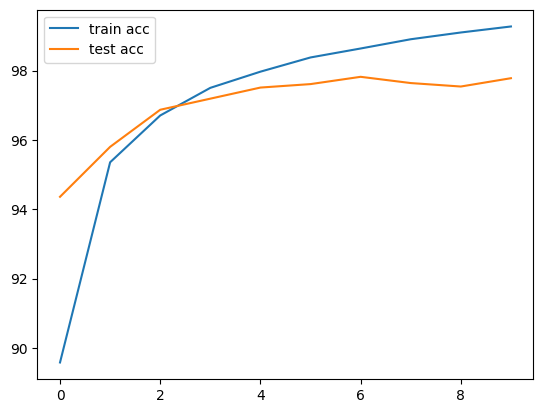

In [49]:
plt.plot(train_acc, label = "train acc");
plt.plot(test_acc, label = "test acc");
plt.legend();

In [50]:
# NEW UNSEEN DATA
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [51]:
with torch.no_grad():
    correct = 0

    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [52]:
correct.item()/len(test_data)

0.9778

In [53]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 970,    0,    4,    1,    1,    2,    5,    3,    4,    3],
       [   0, 1125,    2,    0,    0,    0,    3,    7,    0,    2],
       [   1,    3, 1004,    3,    1,    0,    2,   10,    4,    0],
       [   3,    2,    6,  988,    0,   11,    1,    2,    3,    4],
       [   0,    0,    2,    0,  964,    2,    2,    2,    3,   10],
       [   0,    0,    0,    6,    0,  868,    4,    1,    3,    2],
       [   1,    1,    2,    0,    6,    2,  940,    0,    1,    0],
       [   1,    0,    4,    5,    1,    0,    0,  986,    2,    0],
       [   3,    4,    8,    3,    1,    6,    1,    2,  950,    5],
       [   1,    0,    0,    4,    8,    1,    0,   15,    4,  983]],
      dtype=int64)